# Analysis of CO₂ Emissions in Italy (1990–2023)

This notebook analyzes Italy’s CO₂ emission trends using official data from 
**ISPRA** (Italian Institute for Environmental Protection and Research).

Raw Excel files are parsed and cleaned with `extraction.py`, which produces:  
- `data_processed/co2_emissions_all_years.csv` (CO₂ by sector and year)  

This notebook covers:  
- visualization of total national emissions over time  
- comparison of emissions with and without LULUCF  
- calculation of percentage changes from baseline years (1990, 2008, 2023)  
- sector-level contributions using pivot tables and charts

The policy dataset is available in:  
`data_processed/policies.csv`  




## Importing necessary data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.style.use("ggplot")

path_emissions = "D:/Python projects and excercises/co2-emissions-italy/data_processed/co2_emissions_all_years.csv"
df = pd.read_csv(path_emissions)
df["CO2 emissions (kt)"] = pd.to_numeric(df["CO2 emissions (kt)"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

path_policies = "D:/Python projects and excercises/co2-emissions-italy/data_processed/policies.csv"
policies = pd.read_csv(path_policies)
policies["Year"] = pd.to_numeric(policies["Year"], errors="coerce")

## CO₂ Total emissions by year (1990-2023)


### CO₂ emissions in Italy
The figure shows Italy's total CO₂ emissions (1990–2023) with selected policy milestones.  

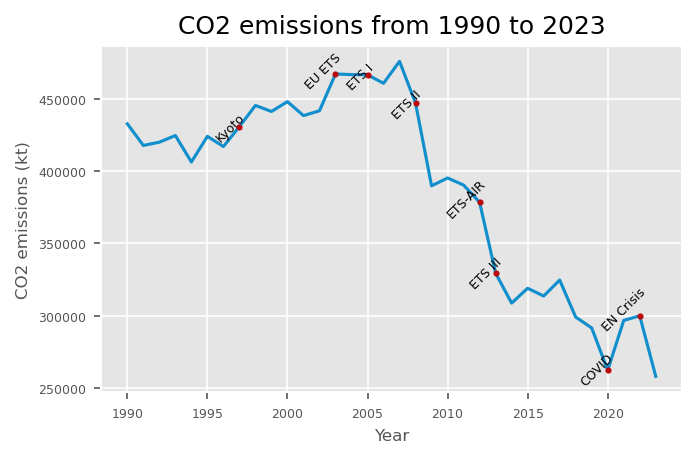

In [4]:
df_tot = df[df["Category"] == "Total national emissions and removals"]
x = df_tot["Year"]
y = df_tot["CO2 emissions (kt)"]

plt.figure(figsize=(5,3), dpi=150)
plt.plot(x,y, color="#118FCD", label="Emissions")
plt.xlabel("Year", fontsize=8)
plt.xticks(fontsize=6)
plt.ylabel("CO2 emissions (kt)", fontsize=8)
plt.yticks(fontsize=6)
plt.title("CO2 emissions from 1990 to 2023", fontsize=12)

labels_sel = {"Kyoto", "EU ETS", "ETS I", "ETS II", "ETS III", "ETS-AIR", "COVID", "EN Crisis"}
pol_subset = policies[policies["ShortLabel"].isin(labels_sel)]


for i,row in pol_subset.iterrows():
    year: int = int(row["Year"])
    policy = row["ShortLabel"]

    if year in df_tot["Year"].values:
        year_emissions = df_tot.loc[df_tot["Year"] == year, "CO2 emissions (kt)"].iloc[0]
        plt.scatter(year, year_emissions, color="#BC0808", zorder=5, s=6)
        plt.annotate(policy, (year, year_emissions), fontsize=6, rotation=45, ha="right", textcoords="offset points", xytext=(4,-7))



plt.show()

Line plot of total national emissions.   
- This visualization shows how there has been a significant drop in emissions over the years.
- The most relevant decreases usually follow major EU policies.
- Year 2020's data was heavily affected by COVID.
- The latest most significant drop is related to the energy crisis started in 2022.


### Difference in emissions (1990 vs 2023)

In [5]:
df_sectors = df[df["Category"] != "Total national emissions and removals"]
df_sectors = df_sectors[df_sectors["Category"] != "4.  Land use, land-use change and forestry"]
df_sectors = df_sectors[df_sectors["Category"] != "6.  Other   (please specify)"]
df_sectors = df_sectors[(df_sectors["Year"] == 1990) | (df_sectors["Year"] == 2023)]

pivoted = df_sectors.pivot_table(index="Category",columns="Year",values="CO2 emissions (kt)")
pivoted.index.name = None

val_1990 = pivoted[1990]
val_2023 = pivoted[2023]

diff = (val_2023 - val_1990) / val_1990 * 100
pivoted["Diff (%)"] = diff
print(pivoted.round(2))

Year                                           1990       2023  Diff (%)
1. Energy                                 409194.15  299152.14    -26.89
2.  Industrial processes and product use   27992.01   12590.48    -55.02
3.  Agriculture                              509.87     441.78    -13.35
5.  Waste                                    512.01     106.26    -79.25
Emissions without LULUCF                  438208.03  312290.65    -28.73


The table shows the total emissions from each sector (excluding land Use, land-Use change and forestry) in the years 1990 and 2023.  
The data shows a significant decrease across all sectors, highlighting the effectiveness of policies and changes put in place over the years.

## Land Use, Land-Use Change and Forestry (1990-2023)

### Contribution of LULUCF to emissions
The following figure shows trend of the net contribution of the LULUCF sector to national emissions since 1990.

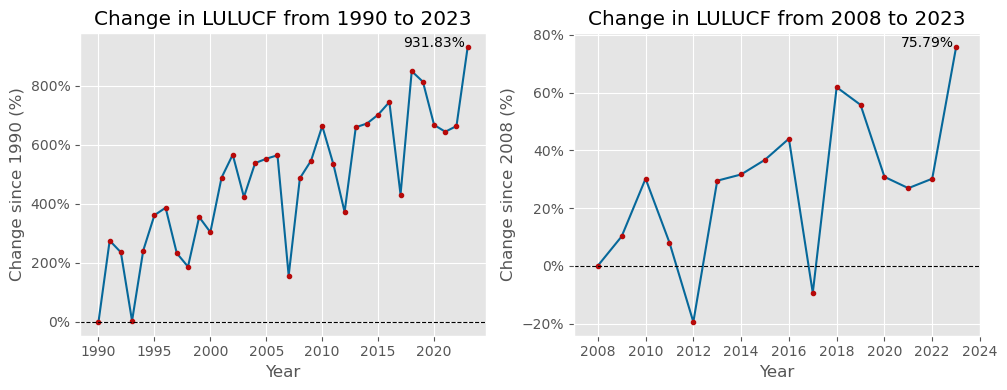

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
df_lulucf = df[df["Category"] == "4.  Land use, land-use change and forestry"].copy()


#1990
base_1990 = df_lulucf.loc[df_lulucf["Year"] == 1990, "CO2 emissions (kt)"].iloc[0]
df_lulucf["Change from 1990"] = -((df_lulucf["CO2 emissions (kt)"] - base_1990) / abs(base_1990) * 100)

axes[0].plot(df_lulucf["Year"], df_lulucf["Change from 1990"], color="#06689A", 
         marker="o", markerfacecolor="#B70A0A", markeredgecolor="#B70A0A", markersize=3)
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Change since 1990 (%)")
axes[0].set_title("Change in LULUCF from 1990 to 2023")
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())

x_2023 = df_lulucf["Year"].iloc[-1]
y_1990_2023 = df_lulucf["Change from 1990"].iloc[-1]
axes[0].plot(x_2023,y_1990_2023)
axes[0].text(x_2023 - 0.2,y_1990_2023, f"{y_1990_2023.round(2)}%", ha="right")

#2008
df_2008 = df_lulucf[df_lulucf["Year"] >= 2008].copy()
base_2008 = df_2008.loc[df_2008["Year"] == 2008, "CO2 emissions (kt)"].iloc[0] #type: ignore
df_2008["Change from 2008"] = -((df_2008["CO2 emissions (kt)"] - base_2008) / abs(base_2008) * 100)

axes[1].plot(df_2008["Year"], df_2008["Change from 2008"], color="#06689A", 
         marker="o", markerfacecolor="#B70A0A", markeredgecolor="#B70A0A", markersize=3)

axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)
axes[1].margins(x=0.2)
axes[1].set_xlim(2007, 2024)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Change since 2008 (%)")
axes[1].set_title("Change in LULUCF from 2008 to 2023")
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())

x_2008_2023 = df_2008["Year"].iloc[-1]
y_2008_2023 = df_2008["Change from 2008"].iloc[-1]
axes[1].plot(x_2008_2023,y_2008_2023)
axes[1].text(x_2008_2023 - 0.1,y_2008_2023, f"{y_2008_2023.round(2)}%", ha="right")

plt.tight_layout()
plt.show()

The chart highlights changes in net CO₂ removals from LULUCF compared to baseline year.
- The left panel shows the percentage change of LULUCF relative to 1990, the official baseline year used in inventories.  
- The right panel uses 2008 as baseline, to highlight the more recent evolution during the period influenced by EU climate policies and economic shifts.  


### Contribution of LULUCF in emission decrease

This section compares total CO₂ emissions including and excluding the LULUCF sector.  
A pivot table is built for three reference years (1990, 2008, 2023) to quantify the absolute values and the percentage contribution of LULUCF to national totals. 

Year  Total without LULUCF    LULUCF  Total with LULUCF  % of emissions
1990             438208.03  -5271.31          432936.73            1.20
2008             478131.96 -30940.99          447190.97            6.47
2023             312290.65 -54391.09          257899.57           17.42


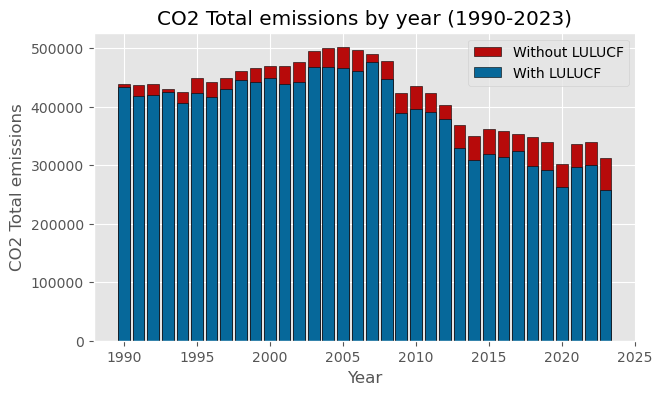

In [7]:
df_tot = df[df["Category"] == "Total national emissions and removals"]
df_nolulucf = df[df["Category"] == "Emissions without LULUCF"]

to_pivot = df[(df["Category"] == "Total national emissions and removals") | 
              (df["Category"] == "Emissions without LULUCF") |
              (df["Category"] == "4.  Land use, land-use change and forestry")]
to_pivot = to_pivot[(to_pivot["Year"] == 1990) | (to_pivot["Year"] == 2008) | (to_pivot["Year"] == 2023)]

pivoted= to_pivot.pivot_table(index="Year", columns="Category", values="CO2 emissions (kt)")
pivoted = pivoted.rename(columns={
    "Total national emissions and removals": "Total with LULUCF",
    "Emissions without LULUCF": "Total without LULUCF",
    "4.  Land use, land-use change and forestry": "LULUCF"
})
pivoted = pivoted[["Total without LULUCF", "LULUCF", "Total with LULUCF"]]

lulucf_val = pivoted["Total with LULUCF"] - pivoted["Total without LULUCF"]
perc = abs(lulucf_val / pivoted["Total without LULUCF"]) * 100
pivoted["% of emissions"] = perc

pivoted.index.name = None
pivoted.columns.name = "Year"
print(pivoted.round(2))

x = df_tot["Year"]
y = df_tot["CO2 emissions (kt)"]
y2 = df_nolulucf["CO2 emissions (kt)"]

plt.figure(figsize=(7,4))
plt.bar(x,y2, color = "#B70A0A", label="Without LULUCF", edgecolor="black", linewidth=0.4)
plt.bar(x,y, color="#06689A", label="With LULUCF", edgecolor="black", linewidth=0.4)

plt.xlabel("Year")
plt.ylabel("CO2 Total emissions")
plt.title("CO2 Total emissions by year (1990-2023)")
plt.legend()
plt.show()

The table reports total emissions with and without LULUCF, the LULUCF contribution in kt, and its amount as percentage of total emissions.
The bar chart shows both series across the whole 1990-2023 period:
- The red bar represents total emissions without LULUCF contribution.
- The blue bar represents emission with LULUCF contribution.
- The difference between the two corresponds to net absorption of the LULUCF sector.

## Conclusions
- There has been a clear reduction of CO₂ emissions in Italy over the years, across all sectors. 
- The decrease has been more visible after the late 2000s.   
- LULUCF absorption of CO₂ has increased, reducing the overall emissions further.